# Text Classification

The present notebook aims to make an exploratory analysis and build a classification model able to categorize search terms.

In [25]:
import sys
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

PROJECT_PATH = os.getcwd()
sys.path.append(PROJECT_PATH)

## Data

Data contains 606823 examples and  1419 different categories.

In [136]:
data = pd.read_csv("data/trainSet.csv", header=None, names=['term','category'])
data.head()

,term,category
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606823 entries, 0 to 606822
Data columns (total 2 columns):
term        606823 non-null object
category    606823 non-null int64
dtypes: int64(1), object(1)
memory usage: 9.3+ MB


In [3]:
most_freq = data.groupby(['category']).count().sort_values('term', ascending=False).head(10)
less_freq = data.groupby(['category']).count().sort_values('term', ascending=True).head(10)

In [4]:
less_freq

,term
category,
587,4
826,10
554,14
1309,14
173,16
619,17
615,19
1105,21
865,23


In [47]:
data[data.category==587].term

124007    client onboarding investment banking
143201                        fintech big data
333393        innovation in financial services
373542                           m commerce uk
Name: term, dtype: object

In [5]:
most_freq

,term
category,
54,623
1026,609
39,609
291,608
533,607
81,607
567,606
1245,605
742,605


In [178]:
data[data.category==54].term

1682            saab 9 3 tuning parts
1942                   psi tuning box
2194                    1.2 tsi remap
3119                   vw bora tuning
4770         diesel tuning north east
10230                 obd chip tuning
11219                       powerchip
11755                     335d tuning
12901                audi s4 b8 remap
13434            mercedes chip tuning
15194               audi a4 b8 tuning
15868                      vtech till
15883          fiat 500 abarth tuning
16154                 mercedes tuning
19574            amd tuning essex ltd
20698           audi a8 3.0 tdi remap
21358        chip tuning box problems
21595                    tuning drums
23561                  bmw 525d remap
24118           vw bora 1.9 tdi remap
24364             audi a3 8p body kit
26640                      bmw tuning
27084                  vw chip tuning
27710       diesel chip tuning review
27883              diesel chip tuning
29083                      obd2 gauge
29981       

- The classes are no well balanced. There are several classes with just few examples and others with more than 600 of examples. For instance, the class $587$ has just only 4 examples, and it seems related to the finance sector. Whereas the class $54$ has 623 examples, and it is maybe related to vehicle features.


- The model will have difficulties to accurately classify the search terms with low quantity of examples.



## Text Processing

Before start with the modeling I will pre-process the data and generate some features that could help during the classification.

- The current dataset does not seem to have unwanted characters like capitals, puntuation  or strange symbols.


- I will just remove the stop words with the Scipy English dictionary. Unlike NLTK, this library will take care about the apostrophes that ocurre often in this dataset.


- I will also implement lemmatization during the cleaning.

In [65]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
nlp = English()

In [140]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text_nltk(text):
    # delete stopwors from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text
    
data['text_clean_nltk'] = data['term'].apply(clean_text_nltk)
data.head()

,term,category,text_clean_nltk
0,yew hedge,1221,yew hedge
1,fire detection shop,19,fire detection shop
2,cheap couch roll,398,cheap couch roll
3,extra watermelon gum,1108,extra watermelon gum
4,used generators for sale uk,213,used generators sale uk


In [75]:
data.iloc[605809]

term          miss peregrine's school for peculiar children
category                                                948
term_clean        miss peregrine's school peculiar children
Name: 605809, dtype: object

In [141]:
def clean_text_scipy(text):
    text = nlp(text)
    # delete stopwors from text and implement lemmatization
    text = ' '.join(str(word.lemma_) for word in text if not word.is_stop) 
    return text
    
data['text_clean_scipy'] = data['term'].apply(clean_text_scipy)
data.head()

,term,category,text_clean_nltk,text_clean_scipy
0,yew hedge,1221,yew hedge,yew hedge
1,fire detection shop,19,fire detection shop,fire detection shop
2,cheap couch roll,398,cheap couch roll,cheap couch roll
3,extra watermelon gum,1108,extra watermelon gum,extra watermelon gum
4,used generators for sale uk,213,used generators sale uk,generators sale uk


In [110]:
data[data.text_clean_scipy==''].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 9180 to 596076
Data columns (total 4 columns):
term                46 non-null object
category            46 non-null int64
text_clean_nltk     46 non-null object
text_clean_scipy    46 non-null object
dtypes: int64(1), object(3)
memory usage: 1.8+ KB


In [118]:
data[data.text_clean_scipy==''].groupby(['category'])['term'].count()

category
45      1
48      1
119     9
205     1
218     1
256     1
286     3
304     1
415     1
430     1
437     2
553     1
573     1
607     3
645     1
672     1
682     1
720     1
798     1
810     1
832     2
841     1
983     1
1004    1
1020    1
1050    1
1259    1
1283    1
1284    1
1295    1
1300    1
1363    1
Name: term, dtype: int64

In [142]:
data = data[data.text_clean_scipy!='']
len(data.category.unique())

1419

Around 46 examples only contain stop words, therefore after the cleaning, I got some empty fields. Since the size of the dataset is large enough and the categories of those examples won't be affected if reducing events, I will just remove those examples.

I do not have much information about the categories and since there are 1419 it is difficult to extract unique features from them, but I would like to build some other features to see if there exists any kind of relationship with the classes.

In [143]:
def feature(df) :
    df['word_count'] = df['text_clean_scipy'].apply(lambda x : len(x.split()))
    df['char_count'] = df['term'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['total_length'] = df['term'].apply(len)
    df['num_symbols'] = df['term'].apply(lambda x: sum(x.count(w) for w in '?^!*&$%'))
    df['num_unique_words'] = df['term'].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    return df

In [144]:
data = feature(data)
data.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,term,category,text_clean_nltk,text_clean_scipy,word_count,char_count,word_density,total_length,num_symbols,num_unique_words,words_vs_unique
0,yew hedge,1221,yew hedge,yew hedge,2,8,0.222222,9,0,2,1.000000
1,fire detection shop,19,fire detection shop,fire detection shop,3,17,0.166667,19,0,3,1.000000
2,cheap couch roll,398,cheap couch roll,cheap couch roll,3,14,0.200000,16,0,3,1.000000
3,extra watermelon gum,1108,extra watermelon gum,extra watermelon gum,3,18,0.157895,20,0,3,1.000000
4,used generators for sale uk,213,used generators sale uk,generators sale uk,3,23,0.125000,27,0,5,1.666667


In [72]:
data[data.num_symbols>1]

,term,category,text_clean_nltk,text_clean_scipy,word_count,char_count,word_density,total_length,num_symbols,num_unique_words,words_vs_unique
353690,baylis & harding sweet mandarin & grapefruit,1402,baylis & harding sweet mandarin & grapefruit,baylis & harding sweet mandarin & grapefruit,7,38,0.179487,44,2,6,0.857143
546240,city & guilds 2365 course level 2 & 3 diploma,494,city & guilds 2365 course level 2 & 3 diploma,city & guilds 2365 course level 2 & 3 diploma,10,36,0.270270,45,2,9,0.900000


Text(0.5,1,'The average length for most frequent categories')

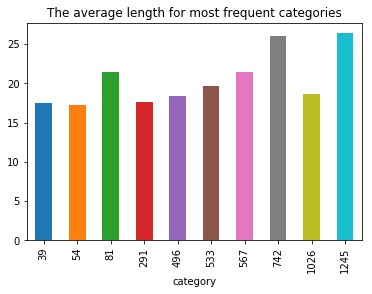

In [79]:
data[data.category.isin(most_freq.index)].groupby(['category']).total_length.mean().plot.bar()
plt.title('The average length for most frequent categories')

Text(0.5,1,'The average length for less frequent categories')

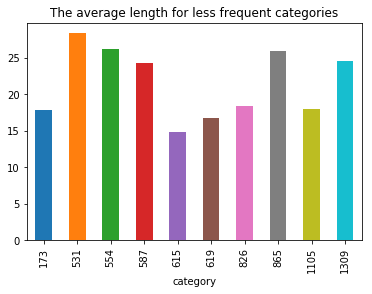

In [80]:
data[data.category.isin(less_freq.index)].groupby(['category']).total_length.mean().plot.bar()
plt.title('The average length for less frequent categories')

In [86]:
data[data.category==180]

,term,category,text_clean_nltk,text_clean_scipy,word_count,char_count,word_density,total_length,num_symbols,num_unique_words,words_vs_unique
34,verisure alarm,180,verisure alarm,verisure alarm,2,13,0.142857,14,0,2,1.0
3127,diy alarm systems,180,diy alarm systems,diy alarm systems,3,15,0.187500,17,0,3,1.0
4403,smoke alarm installation,180,smoke alarm installation,smoke alarm installation,3,22,0.130435,24,0,3,1.0
7255,wireless burglar alarm uk,180,wireless burglar alarm uk,wireless burglar alarm uk,4,22,0.173913,25,0,4,1.0
10659,yale alarm kit,180,yale alarm kit,yale alarm kit,3,12,0.230769,14,0,3,1.0
10809,home security systems uk,180,home security systems uk,home security systems uk,4,21,0.181818,24,0,4,1.0
11687,burglar alarm control panel,180,burglar alarm control panel,burglar alarm control panel,4,24,0.160000,27,0,4,1.0
11766,yale key fob,180,yale key fob,yale key fob,3,10,0.272727,12,0,3,1.0
11865,yale shed and garage alarm,180,yale shed garage alarm,yale shed garage alarm,5,22,0.217391,26,0,5,1.0
12232,alarme,180,alarme,alarme,1,6,0.142857,6,0,1,1.0


I tried to find a relationship between the new features and the categories looking at the most frequent and less frequent classes but there is not a clear distinction between them. I don't think they will add information during the classification. 

## Modeling

In [145]:
X = data.text_clean_scipy
y = data.category.astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Since I was not able to extract useful features, a simple model should be the best option in this case. 

I will start with Naive Bayes, which will give me a baseline for the classification. The Multinominal Naive Bayes is chosen since the data will be represented as vectors through a tfidf matrix.

The metric I will use to evaluate the models will be the F1-score. This is the most suitable since the classes are not well balanced on the dataset.

### 1. Naive Bayes

In [156]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [127]:
target_names=list(map(str,data.category.unique()))
print('F1 score %s' % f1_score(y_pred, y_test, average='weighted'))
print(classification_report(y_test, y_pred,target_names=target_names))

F1 score 0.5955950571237875
             precision    recall  f1-score   support

       1221       0.80      0.72      0.76       132
         19       0.45      0.68      0.54       114
        398       0.48      0.74      0.58       170
       1108       0.62      0.25      0.36       131
        213       0.45      0.86      0.59       160
        821       0.46      0.73      0.56       124
        958       0.50      0.12      0.20        96
        562       0.00      0.00      0.00        82
        158       0.36      0.52      0.43        84
        225       0.52      0.54      0.53       142
       1350       0.59      0.37      0.45       139
        228       0.47      0.78      0.59       155
        248       0.31      0.04      0.07       106
       1069       0.61      0.73      0.66       171
        823       0.60      0.50      0.54       125
        343       0.68      0.62      0.65       178
        580       0.56      0.48      0.52       166
        599      

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [171]:
pred = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test}, columns=['y_pred', 'y_test'])

In [179]:
pred[pred.y_test=='239'].head()

,y_pred,y_test
43946,582,239
572111,1220,239
538548,582,239
118275,990,239
46464,582,239


In [182]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [42]:
show_most_informative_features(nb.steps[0][1],nb.steps[-1][1])

	-10.9915	00             		-6.0047	domain         
	-10.9915	000            		-7.9608	buy            
	-10.9915	0000           		-8.2672	hosting        
	-10.9915	00003          		-8.4195	domains        
	-10.9915	00003f         		-8.6191	uk             
	-10.9915	001            		-8.6722	website        
	-10.9915	003            		-8.7526	web            
	-10.9915	006            		-8.7800	names          
	-10.9915	007            		-8.9449	check          
	-10.9915	008            		-9.0579	purchase       


- F1-score of around 60% does not seem that bad taking into account that I was not performing any feature engineering and there are more than 1k of different categories.


- The category with the lowest number of examples got an F1-score of 71%, while the most frequent category has a score of 15% with high precision and low recall, which means a high number of false negatives, as pointed out previously this class is related to vehicles with a broad vocabulary, a lot of references and technical words that could be difficult to classify.


- For some classes, the f1-score is zero. In those cases, the classifier predicts the class with another very similar like in the case of the classes $239$ and $582$, both related to bedroom accessories and without a straightforward distinction. Nevertheless, I think the classifier is doing a good job in those categories too.


-  I printed the most and less important categories. The less informative ones are shown at the left and the most informative ones are shown at the right. The less important features are just numbers, but I will keep them since many of them are used as a reference within the search terms and also taking into account that there is not much difference between these and the most important features. 

### 2. Linear Support Vector Machine

In [180]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

In [27]:
from sklearn.metrics import classification_report
target_names=list(map(str,data.category.unique()))
print('F1 score %s' % f1_score(y_pred, y_test, average='weighted'))
print(classification_report(y_test, y_pred,target_names=target_names))

F1 score 0.5262072127939046
             precision    recall  f1-score   support

       1221       0.74      0.74      0.74       132
         19       0.53      0.64      0.58       114
        398       0.69      0.49      0.58       170
       1108       0.29      0.02      0.03       131
        213       0.63      0.75      0.69       160
        821       0.47      0.73      0.57       124
        958       0.45      0.23      0.30        96
        562       0.00      0.00      0.00        82
        158       0.40      0.37      0.39        84
        225       0.68      0.46      0.55       142
       1350       0.61      0.40      0.48       139
        228       0.63      0.61      0.62       155
        248       0.00      0.00      0.00       106
       1069       0.64      0.69      0.66       171
        823       0.51      0.29      0.37       125
        343       0.72      0.68      0.70       178
        580       0.51      0.54      0.53       166
        599      

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [183]:
show_most_informative_features(sgd.steps[0][1],sgd.steps[-1][1])

	-0.0034	finder         		0.2282	domain         
	-0.0024	discount       		0.0155	domains        
	-0.0023	netflix        		0.0127	url            
	-0.0022	property       		0.0088	whois          
	-0.0020	ly             		0.0085	dns            
	-0.0020	freeparking    		0.0045	webspace       
	-0.0020	gg             		0.0040	backorder      
	-0.0020	fasthosts      		0.0039	godaddy        
	-0.0019	squarespace    		0.0039	tld            
	-0.0018	se             		0.0028	expired        


- F1-score of 53%, lower than the Naive Bayes classifier.


- Same as in the previous model, the model does a good job even in the classes with few examples. But it gives an accurate classification for those similar categories that the NB model does not.


- With this model, there is a difference in the importance of the features. The most important ones are similar as in the Naive Bayes model but the less informative ones aren't numbers anymore.

### 3. Naive Bayes with extra features

Just to check I will include the extracted features in the model.

In [184]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler = MinMaxScaler()
feat = data[['word_count','char_count','word_density','total_length','num_symbols','num_unique_words','words_vs_unique']]
#feat = np.log10(feat)
feat = scaler.fit_transform(feat)
feat = pd.DataFrame(feat)

In [79]:
feat.head()

,word_count,char_count,word_density,total_length,num_symbols,num_unique_words,words_vs_unique
0,2,8,0.222222,9,0,2,1.0
1,3,17,0.166667,19,0,3,1.0
2,3,14,0.200000,16,0,3,1.0
3,3,18,0.157895,20,0,3,1.0
4,4,20,0.190476,23,0,4,1.0


In [186]:
tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(data.text_clean_scipy)

print(x.shape)

(606777, 68726)


In [187]:
import scipy as sp
x = sp.sparse.hstack((x, feat))
x.shape

(606777, 68733)

In [188]:
X = x
y = data.category.astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [189]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [190]:
target_names = list(map(str,data.category.unique()))
print('F1-score %s' % f1_score(y_pred, y_test, average='weighted'))
print(classification_report(y_test, y_pred,target_names=target_names))

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1-score 0.5695528117449719
             precision    recall  f1-score   support

       1221       0.77      0.71      0.74       140
         19       0.57      0.46      0.51       127
        398       0.51      0.29      0.37       124
       1108       0.00      0.00      0.00        83
        213       0.42      0.81      0.55       155
        821       0.55      0.83      0.66       183
        958       0.53      0.73      0.62       181
        562       0.65      0.72      0.69       156
        158       1.00      0.01      0.02        95
        225       0.55      0.68      0.61       154
       1350       0.62      0.78      0.69       170
        228       0.75      0.73      0.74       177
        248       0.00      0.00      0.00        60
       1069       0.69      0.83      0.75       179
        823       0.48      0.85      0.61       181
        343       1.00      0.02      0.04        89
        580       0.47      0.08      0.13       104
        599      

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As I expected, the extracted features didn't help in the classification and the f1-score decreased by 3 porcentage points.

### 4. Transformation with word2vec

I would like to try one more thing, I will load a word2vec pre-trained model to map the text, average the vectors and see if I can improve the prediction. 

In [191]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [192]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [194]:
import gensim
def w2v_tokenize_text(text):
    tokens = []
    for word in nltk.word_tokenize(text, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(data, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['text_clean_scipy']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['text_clean_scipy']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  


In [57]:
X_train_word_average

array([[ 0.06177364,  0.00025883, -0.01520202, ...,  0.00869426,
         0.0161774 ,  0.04412364],
       [ 0.01348261,  0.16015707,  0.00980553, ...,  0.07681002,
         0.09642109, -0.05556469],
       [ 0.02919473, -0.0093522 , -0.09493437, ...,  0.01631127,
        -0.03969059, -0.01828078],
       ...,
       [-0.05718163,  0.01870781, -0.01000075, ..., -0.06840227,
        -0.06271318,  0.05190369],
       [-0.0306299 ,  0.0575814 , -0.05275157, ..., -0.0103231 ,
         0.00369111,  0.06376543],
       [-0.07734306, -0.00186015, -0.03914212, ...,  0.00590358,
         0.02440338, -0.06953044]])

In [195]:
sgd = SGDClassifier(alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd=sgd.fit(X_train_word_average, train['category'])

y_pred = sgd.predict(X_test_word_average)

In [196]:
target_names=list(map(str,data.category.unique()))
print('F1-score %s' % f1_score(y_pred, test.category, average='weighted'))
print(classification_report(test.category, y_pred,target_names=target_names))

F1-score 0.46649278280788903
             precision    recall  f1-score   support

       1221       0.62      0.74      0.68       140
         19       0.48      0.46      0.47       127
        398       0.75      0.44      0.56       162
       1108       0.51      0.14      0.22       129
        213       0.60      0.85      0.70       157
        821       0.44      0.59      0.50       154
        958       0.00      0.00      0.00        94
        562       0.01      0.04      0.01        82
        158       0.51      0.25      0.34       100
        225       0.64      0.45      0.52       130
       1350       0.56      0.07      0.13       124
        228       0.82      0.55      0.66       179
        248       1.00      0.01      0.02       104
       1069       0.52      0.49      0.50       161
        823       0.61      0.15      0.25       124
        343       0.67      0.56      0.61       162
        580       0.44      0.44      0.44       156
        599     

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


I used the SVM with word2vec. I didn't get a good performance, it decreased the SVM performance by 6 porcentage points.

## Conclusions

- The data set has many classes and it is difficult to extract unique characteristics from them. More information about the categories would help to perform a correct feature engineering.


- I tried to build a baseline with a simple model like Naive Bayes, and it turned out that outperformed the SVM. Due to the lack of time I didn't try to tune the classifier or implement more complex models, I think this could help to improve the results.


- I would also like to inspect the sentence representations with Gensim Doc2vec implementation and check if this improves my score.
